# imports

In [182]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import networkx as nx
import re
import math

import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.linear_model import LogisticRegression as logreg
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier as dectree

[nltk_data] Downloading package stopwords to C:\Users\Harrison
[nltk_data]     Lu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# explore data

In [2]:
df = pd.read_csv('./dataset/sentiment140/data.csv', encoding='latin-1', header = None)
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'text']

df = df.applymap(lambda s: s.lower() if type(s) == str else s)
df.head()

,sentiment,ID,date,query,username,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,@kenichan i dived many times for the ball. man...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,"@nationwideclass no, it's not behaving at all...."


# splitting entire dataset

not used in experiment below yet

In [3]:
dfTrain = df.sample(frac = 0.8, random_state = 20)
dfTest = df.drop(dfTrain.index)

dfGraphModel = dfTrain.sample(frac = 0.5, random_state = 20)
dfDM = dfTrain.drop(dfGraphModel.index)

#subset of the dfTrain dataset, split into positive, negative, and neutral tweets
pos = dfGraphModel.loc[df['sentiment'] == 4]
neg = dfGraphModel.loc[df['sentiment'] == 0]
neut = dfGraphModel.loc[df['sentiment'] == 2]

posText = {line["ID"]: line["text"] for index, line in pos.iterrows()}
negText = {line["ID"]: line["text"] for index, line in neg.iterrows()}

posWords = [line.rstrip('\n') for line in open('./dataset/positive-words.txt') if line.split() and list(line)[0] != ';']
negWords = [line.rstrip('\n') for line in open('./dataset/negative-words.txt') if line.split() and list(line)[0] != ";"]

# filtering by target word "food"
also removing handles. 

result in 4000 something tweets

In [31]:
subjectTweetsDict = {} # key = index in original df and value = tweet info (sentiment, id, date, query, username, full tweet)
filteredTweets = {} # key = index in original df and value = filtered tweet
count = 0
for row in df.itertuples():
    if 'food' in row[6]:
        subjectTweetsDict[row[0]] = list(row)[1:7]
        word_tokens = str(row[6]).split() #split by white space
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        filtered_sentence = [] 
        i = 0
        while i < len(word_tokens):
            if '@' in word_tokens[i]: #Taking out handles from tweets
                i = i + 1
            elif word_tokens[i] not in stop_words:
                filtered_sentence.append(word_tokens[i])
            i = i + 1
        filteredTweets[row[0]] = filtered_sentence
#print(subjectTweetsDict)
#df2 = pd.DataFrame(data=subjectTweetsDict, columns = ['index', 'sentiment', 'id', 'date', 'query', 'username', 'tweet'])
dfSubject= pd.DataFrame.from_dict(subjectTweetsDict, orient = 'index', columns = ['sentiment', 'id', 'date', 'query', 'username', 'text'])
for key, value in filteredTweets.items():
    filteredString = ' '.join(value)
    dfSubject.at[key, "text"] = filteredString

dfSubject.tail()

len(dfSubject)

8440

## splitting our dataset into training, testing set.
split training into creating graph model, as well as creating the data mining model. 
split graph model into positive, negative, and neutral.

no neutral tweets, as we have found

In [6]:
dfTrain = dfSubject.sample(frac = 0.8, random_state = 20)
dfTest = dfSubject.drop(dfTrain.index)

dfGraphModel = dfTrain.sample(frac = 0.6, random_state = 20)
dfDM = dfTrain.drop(dfGraphModel.index)

posSubject = dfGraphModel.loc[dfSubject['sentiment'] == 4]
negSubject = dfGraphModel.loc[dfSubject['sentiment'] == 0]
neutSubject = dfGraphModel.loc[dfSubject['sentiment'] == 2] #there is no neutral

# writing functions to evaluate how each model works

In [9]:
'''this function creates the word graph given the text in the tweet and the 
frame that is used to create the graph model. Can accept both an array of strings to 
treat as one long string, or a single string.'''

def createGraphFromTweet(text, frame):
    wordGraph = nx.DiGraph()
    if type(text) == str:
        createGraph(text, wordGraph, frame)
    if type(text) == list:
        for element in text:
            createGraph(element, wordGraph, frame)
    return wordGraph

'''helper function- NOT FOR USE.'''
def createGraph(text, wordGraph, frame):
    if text:
        text = re.sub(r'[^\w\s]', '', str(text))
        text = text.split()
        try:
            if len(text) == 1:
                wordGraph.add_edge(text[0], text[0], weight = 1)
            for x in range(len(text) - frame):
                for y in range(1, frame + 1):
                    n1 = text[x]
                    n2 = text[x+y]
                    if wordGraph.has_edge(n1, n2):
                        wordGraph[n1][n2]['weight'] = wordGraph[n1][n2]['weight'] + 1
                    else:
                        wordGraph.add_edge(n1, n2, weight = 1)
            for x in reversed(range(1, frame + 1)):
                for y in reversed(range(1, x)):
                    n1 = text[len(text) - x]
                    n2 = text[len(text) - y]
                    if wordGraph.has_edge(n1, n2):
                        wordGraph[n1][n2]['weight'] = wordGraph[n1][n2]['weight'] + 1
                    else:
                        wordGraph.add_edge(n1, n2, weight = 1)
        except IndexError:
            return createGraph(text, wordGraph, frame-1)
        return wordGraph
    else:
        return wordGraph


In [57]:
'''extracting text from the dataframe'''
posArrayText = posSubject.as_matrix(columns = posSubject.columns[-1:]).flatten().tolist()
negArrayText = negSubject.as_matrix(columns = negSubject.columns[-1:]).flatten().tolist()

'''putting text into one large graph'''
posWordGraph = createGraphFromTweet(posArrayText, 10)
negWordGraph = createGraphFromTweet(negArrayText, 10)

C:\Users\Harrison Lu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Harrison Lu\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [180]:
'''GRAPH SIMILARITY FUNCTIONS'''

'''counts the number of identical edges between two graphs, normalizes by the minimum number of nodes in either graph'''
def edgeSimilarity(inputGraph, model):
    count = 0
    for edge in inputGraph.edges():
        n1, n2 = edge
        if model.has_edge(n1, n2): 
            count += 1
    return count/min(len(inputGraph), len(model))

'''returns maximum common subgraph of inputs'''
def getMCS(graphModel, tweetGraph):
    matching_graph = nx.DiGraph()
    for n1, n2 in tweetGraph.edges():
        if graphModel.has_edge(n1, n2):
            matching_graph.add_edge(n1, n2, weight = tweetGraph[n1][n2]['weight'])
    edgeList = list(matching_graph.edges())
    edgeListCopy = edgeList[:]
    nodeList = list(matching_graph.nodes())
    visited = []
    graphArray = []
    while nodeList:
        G = nx.DiGraph()
        parentNode = nodeList.pop(0)
        toRemove = []
        for edge in edgeList:
            n1, n2 = edge
            if parentNode == n1:
                if n2 in nodeList:
                    G.add_edge(n1, n2)
                    toRemove.append(edge)
                    visited.append(n2)
                else:
                    for graph in graphArray:
                        if n2 in graph.nodes():
                            graph.add_edge(n1, n2)
            edgeList = [e for e in edgeList if e not in toRemove]
            toRemove = []
            while visited:
                node = visited.pop(0)
                if node in nodeList:
                    nodeList.remove(node)
                for edge in edgeList:
                    n1, n2 = edge
                    if node == n1: 
                        G.add_edge(n1, n2)
                        toRemove.append(edge)
                        visited.append(n2)
                edgeList = [e for e in edgeList if e not in toRemove]
                toRemove = []
        if len(G) != 0:
            graphArray.append(G)

    size = 0 
    returnGraph = nx.DiGraph()
    for graph in graphArray:
        if len(graph) > size:
            returnGraph = graph
            size = len(graph)
    return returnGraph
        

'''returns number of common nodes in MCS and model graph, normalized by minimum number of nodes'''
def MCSNS(mcs_graph, graphModel, tweetGraph):
    return len(mcs_graph)/min(len(graphModel),len(tweetGraph))

'''returns number of common edges in MCS and model graph, normalized by minimum number of nodes'''
def MCSUES(mcs_graph, graphModel, tweetGraph): 
    return len(mcs_graph.edges())/min(len(graphModel),len(tweetGraph))

'''returns number of common edges in the MCS and model graph, taking direction into account,
normalized by minimum number of nodes'''
def MCSDES(mcs_graph, graphModel, tweetGraph): 
    count = 0
    for e1,e2 in mcs_graph.edges():
        if tweetGraph.has_edge(e1,e2) and graphModel.has_edge(e1,e2):
            count+=1
    return count/min(len(graphModel),len(tweetGraph))

'''tf-idf helper function'''
def calcTotalWords(model):
    total = 0
    for e1,e2 in model.edges(): #total number of edges = sum of weights
        total += model[e1][e2]['weight']
    return total

'''tf-idf method for coming up with vectors, max edge value is taken as representative of
the entire tweet model. Idea is that positive tweet should have a higher pos max than a neg max'''
def tf_idf_max(tweetModel, posModel, negModel): #returns max score for each tweet model
    maxPosVal = []
    maxNegVal = []
    totalPosEdges = calcTotalWords(posModel)
    totalNegEdges = calcTotalWords(negModel)
    for e1,e2 in tweetModel.edges():
        if posModel.has_edge(e1, e2) and negModel.has_edge(e1, e2):      #both models have the edge
            idf = math.log(1)                                #idf = 2 models, both have the edge -> 2/2 = 1
            tf_pos = posModel[e1][e2]['weight'] / totalPosEdges
            tf_neg = negModel[e1][e2]['weight'] / totalNegEdges
            pos_score = idf * tf_pos
            neg_score = idf * tf_neg
            maxPosVal.append(pos_score)
            maxNegVal.append(neg_score)
        elif posModel.has_edge(e1, e2) or negModel.has_edge(e1, e2):          #only one of the models has the edge
            idf = math.log(2)                              #idf: 2 models, only 1 has the edge -> 2/1 = 2
            if posModel.has_edge(e1, e2):
                tf_pos = posModel[e1][e2]['weight'] / totalPosEdges
                pos_score = idf * tf_pos
                maxPosVal.append(pos_score)
            else:
                tf_neg = negModel[e1][e2]['weight'] / totalNegEdges
                neg_score = idf * tf_neg
                maxNegVal.append(neg_score)
    if len(maxPosVal) == 0:
        maxPosVal.append(0)
    if len(maxNegVal) == 0:
        maxNegVal.append(0)
    return max(maxPosVal), max(maxNegVal)


'''tf-idf method for coming up with vectors, avg edge value is taken as representative of
the entire tweet model.'''
def tf_idf_avg(tweetModel, posModel, negModel): #returns average tfidf score for each model
    totalPosEdges = calcTotalWords(posModel)
    totalNegEdges = calcTotalWords(negModel)
    negModelSum = 0
    posModelSum = 0
    totalPosEdgesTweet = 0
    totalNegEdgesTweet = 0
    for e1,e2 in tweetModel.edges():
        if posModel.has_edge(e1, e2) and negModel.has_edge(e1, e2):      #both models have the edge
            idf = math.log(1)                                #idf = 2 models, both have the edge -> 2/2 = 1
            tf_pos = posModel[e1][e2]['weight'] / totalPosEdges
            tf_neg = negModel[e1][e2]['weight'] / totalNegEdges
            pos_score = idf * tf_pos
            neg_score = idf * tf_neg
            posModelSum += pos_score
            negModelSum += neg_score
            totalPosEdgesTweet += 1
            totalNegEdgesTweet += 1
        elif posModel.has_edge(e1, e2) or negModel.has_edge(e1, e2):          #only one of the models has the edge
            idf = math.log(2)                              #idf: 2 models, only 1 has the edge -> 2/1 = 2
            if posModel.has_edge(e1, e2):
                tf_pos = posModel[e1][e2]['weight'] / totalPosEdges
                pos_score = idf * tf_pos
                posModelSum += pos_score
                totalPosEdgesTweet += 1
            else:
                tf_neg = negModel[e1][e2]['weight'] / totalNegEdges
                neg_score = idf * tf_neg
                negModelSum += neg_score
                totalNegEdgesTweet += 1

    if totalPosEdgesTweet == 0:
        average_tfidf_pos = 0
    else:
        average_tfidf_pos = posModelSum / totalPosEdgesTweet
    if totalNegEdgesTweet == 0:
        average_tfidf_neg = 0
    else:
        average_tfidf_neg = negModelSum / totalNegEdgesTweet
    
    return average_tfidf_pos, average_tfidf_neg

'''weight * ((pos/neg)(pos + neg)). idea is that number of times a word shows up in a positive
vs negative graph matters. eg, if a term shows up an equal number of times in a pos graph as a 
neg graph, then it's a neutral word. '''
def tf_idf2(tweetModel, posModel, negModel): #harrison's method
    allPosScore = []
    allNegScore = []
    for e1, e2 in tweetModel.edges():
        weight_tweet = tweetModel[e1][e2]['weight']
        if posModel.has_edge(e1, e2) and negModel.has_edge(e1, e2):
            weight_pos = posModel[e1][e2]['weight']
            weight_neg = negModel[e1][e2]['weight']
            pos_score = weight_tweet * ((weight_pos/weight_neg)/(weight_pos + weight_neg))
            neg_score = weight_tweet *((weight_neg/weight_pos)/(weight_pos + weight_neg))
            allPosScore.append(pos_score)
            allNegScore.append(neg_score)
        elif posModel.has_edge(e1, e2) or negModel.has_edge(e1, e2):
            if posModel.has_edge(e1, e2):
                weight_pos = posModel[e1][e2]['weight']
                weight_neg = 1
                pos_score = weight_tweet * ((weight_pos/weight_neg)/(weight_pos + weight_neg))
                neg_score = weight_tweet *((weight_neg/weight_pos)/(weight_pos + weight_neg))
            else:
                weight_pos = 1
                weight_neg = negModel[e1][e2]['weight']
                pos_score = weight_tweet * ((weight_pos/weight_neg)/(weight_pos + weight_neg))
                neg_score = weight_tweet *((weight_neg/weight_pos)/(weight_pos + weight_neg))
            allPosScore.append(pos_score)
            allNegScore.append(neg_score)
    if len(allPosScore) == 0:
        allPosScore.append(0)
    if len(allNegScore) == 0:
        allNegScore.append(0)
    return max(allPosScore), max(allNegScore)

def calculateNumberOfGraphs(e1, e2, graph):
    count = 0
    for g in graph:
        if g.has_edge(e1,e2):
            count+=1
    return count

In [179]:
'''generates the feature vectors and labels (posValue, negValue).
   -dataframeDict is the dataframe above turned into a dictionary, with ID as 
   key and the rest of the information as value, stored as a nested dictionary
   -posWordGraph/negWordGraph are our pos/neg graph models
   -metric type refers to one of the above functions listed in the above cell block'''
def generateWordGraphVectors(dataframeDict, posWordGraph, negWordGraph, metricType):
    X = []
    y = []
    count = 0
    for key, value in dataframeDict.items():
        if value['text']:
            y.append(value['sentiment'])
            wordGraph = createGraphFromTweet(value['text'], 4)
            posNegArray = []
            if metricType == "edge":
                posNegArray.append(edgeSimilarity(wordGraph, posWordGraph))
                posNegArray.append(edgeSimilarity(wordGraph, negWordGraph))
            elif metricType == "MCSNS":
                mcs_graph = getMCS(posWordGraph, wordGraph)
                posNegArray.append(MCSNS(mcs_graph, wordGraph, posWordGraph))
                mcs_graph = getMCS(negWordGraph, wordGraph)
                posNegArray.append(MCSNS(mcs_graph, wordGraph, negWordGraph))
            elif metricType == "MCSUES":
                mcs_graph = getMCS(posWordGraph, wordGraph)
                posNegArray.append(MCSUES(mcs_graph, wordGraph, posWordGraph))
                mcs_graph = getMCS(negWordGraph, wordGraph)
                posNegArray.append(MCSUES(mcs_graph, wordGraph, negWordGraph))
            elif metricType == "MCSDES":
                mcs_graph = getMCS(posWordGraph, wordGraph)
                posNegArray.append(MCSDES(mcs_graph, wordGraph, posWordGraph))
                mcs_graph = getMCS(negWordGraph, wordGraph)
                posNegArray.append(MCSDES(mcs_graph, wordGraph, negWordGraph))
            elif metricType == "TFIDF_max":
                pos_avg, neg_avg = tf_idf_max(wordGraph, posWordGraph, negWordGraph)
                posNegArray.append(pos_avg)
                posNegArray.append(neg_avg)
            elif metricType == "TFIDF_avg":
                pos_avg, neg_avg = tf_idf_avg(wordGraph, posWordGraph, negWordGraph)
                posNegArray.append(pos_avg)
                posNegArray.append(neg_avg)
            elif metricType == "TFIDF_2":
                pos_avg, neg_avg = tf_idf2(wordGraph, posWordGraph, negWordGraph)
                posNegArray.append(pos_avg)
                posNegArray.append(neg_avg)
            elif metricType == "TFIDF_3":
                pos_avg, neg_avg = tf_idf3(wordGraph, posWordGraph, negWordGraph)
                posNegArray.append(pos_avg)
                posNegArray.append(neg_avg)
            X.append(posNegArray)
            count += 1
    return X, y


# here we actually start evaluating

In [166]:
'''turn our dataframe into dictionary format'''
sentimentTweetDict = dfDM.to_dict(orient='index')

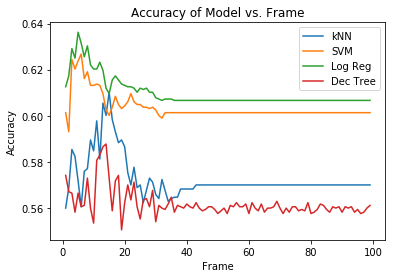

In [209]:
'''evaluate how frame changes accuracy of model'''
ykNN = []
ySVM = []
yLogReg = []
yDecTree = []
xplot = [x for x in range(1, 100)]

for x in range(1, 100):
    posWordGraph = createGraphFromTweet(posArrayText, x)
    negWordGraph = createGraphFromTweet(negArrayText, x)

    X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "edge")
    testDict = dfTest.to_dict(orient='index')
    Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "edge")


    model = kNN(n_neighbors = 5)
    model.fit(X, y)
    ykNN.append(model.score(Xtest, ytest))

    classifier = svm.SVC(kernel = "linear")
    classifier.fit(X, y)
    ySVM.append(classifier.score(Xtest, ytest))

    classifier = logreg()
    classifier.fit(X, y)
    yLogReg.append(classifier.score(Xtest, ytest))

    classifier = dectree()
    classifier.fit(X, y)
    yDecTree.append(classifier.score(Xtest, ytest))


plt.plot(xplot, ykNN, label = "kNN")
plt.plot(xplot, ySVM, label = "SVM")
plt.plot(xplot, yLogReg, label = "Log Reg")
plt.plot(xplot, yDecTree, label = "Dec Tree")
plt.legend()
plt.title("Accuracy of Model vs. Frame")
plt.xlabel("Frame")
plt.ylabel("Accuracy")
plt.show()

In [214]:
'''reset frame'''
posWordGraph = createGraphFromTweet(posArrayText, 3)
negWordGraph = createGraphFromTweet(negArrayText, 3)

In [236]:
def generatePlot(X, y, similarityMeasure):
    xPos = []
    xNeg = []
    yPos = []
    yNeg = []
    for index in range(len(y)):
        if y[index] == 4: 
            xPos.append(X[index][1])
            yPos.append(X[index][0])
        if y[index] == 0: 
            xNeg.append(X[index][1])
            yNeg.append(X[index][0])
    plt.title("Pos/Neg Attribute by " + similarityMeasure)
    plt.xlabel("Negative Attribute")
    plt.ylabel("Positive Attribute")
    plt.scatter(xNeg, yNeg, color = "red", alpha = 0.35, s = 10, label = "negative")
    plt.scatter(xPos, yPos, color = "blue", alpha = 0.15, s = 10, label = "positive")
    plt.legend()
    plt.show()

kNN score: 0.5853080568720379
SVM score: 0.6244075829383886
Logistic regression score: 0.6291469194312796
Decision tree score: 0.5651658767772512


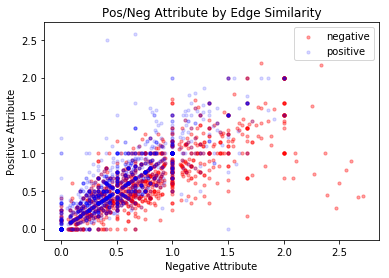

In [237]:
'''evaluate model, vectors generated by edgeSimilarity function. 
   Model evaluated using kNN, SVM, logistic regression, and decision tree.'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "edge")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "edge")


model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

generatePlot(X, y, "Edge Similarity")

kNN score: 0.544431279620853
SVM score: 0.5764218009478673
Logistic regression score: 0.5746445497630331
Decision tree score: 0.5468009478672986


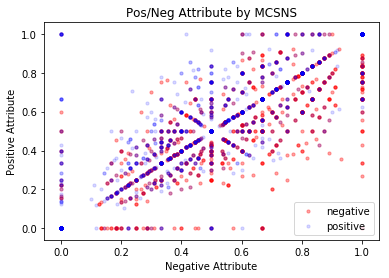

In [238]:
'''identical as above, except vectors generated by MCSNS'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "MCSNS")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "MCSNS")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

generatePlot(X, y, "MCSNS")

kNN score: 0.568127962085308
SVM score: 0.5953791469194313
Logistic regression score: 0.606042654028436
Decision tree score: 0.5622037914691943


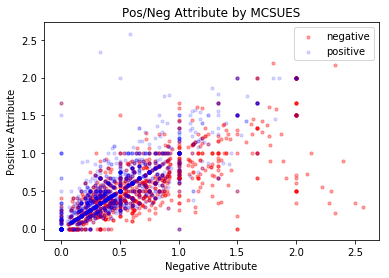

In [239]:
'''identical as above, except vectors generated by MCSUES'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "MCSUES")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "MCSUES")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

generatePlot(X, y, "MCSUES")

kNN score: 0.568127962085308
SVM score: 0.5953791469194313
Logistic regression score: 0.606042654028436
Decision tree score: 0.5622037914691943


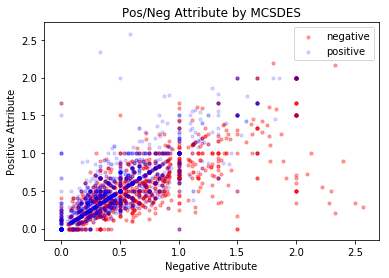

In [240]:
'''identical as above, except vectors generated by MCSDES'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "MCSDES")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "MCSDES")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

generatePlot(X, y, "MCSDES")

# here we start considering edge weights. 
weights = how many times the edge appeared.

In [24]:
'''remove edges that have under a certain weight, also remove isolated 
nodes after we run this function.'''
def removeEdgesByWeight(graph, threshold):
    returnGraph = graph.copy()
    edgeCountDict = nx.get_edge_attributes(returnGraph, 'weight')
    for key, value in edgeCountDict.items():
        if value <= threshold:
            returnGraph.remove_edge(*key)
    emptyNodes = list(nx.isolates(returnGraph))
    returnGraph.remove_nodes_from(emptyNodes)
    return returnGraph

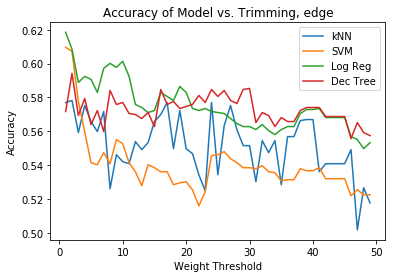

In [267]:
'''evaluate how trimming changes accuracy of model'''
ykNN = []
ySVM = []
yLogReg = []
yDecTree = []
xplot = [x for x in range(1, 50)]

for x in range(1, 50):
    posWordGraphTrimmed = removeEdgesByWeight(posWordGraph, x)
    negWordGraphTrimmed = removeEdgesByWeight(negWordGraph, x)

    X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "edge")
    testDict = dfTest.to_dict(orient='index')
    Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "edge")


    model = kNN(n_neighbors = 5)
    model.fit(X, y)
    ykNN.append(model.score(Xtest, ytest))

    classifier = svm.SVC(kernel = "linear")
    classifier.fit(X, y)
    ySVM.append(classifier.score(Xtest, ytest))

    classifier = logreg()
    classifier.fit(X, y)
    yLogReg.append(classifier.score(Xtest, ytest))

    classifier = dectree()
    classifier.fit(X, y)
    yDecTree.append(classifier.score(Xtest, ytest))


plt.plot(xplot, ykNN, label = "kNN")
plt.plot(xplot, ySVM, label = "SVM")
plt.plot(xplot, yLogReg, label = "Log Reg")
plt.plot(xplot, yDecTree, label = "Dec Tree")
plt.legend()
plt.title("Accuracy of Model vs. Trimming, edge")
plt.xlabel("Weight Threshold")
plt.ylabel("Accuracy")
plt.show()

In [29]:
'''trim edges'''
posWordGraphTrimmed = removeEdgesByWeight(posWordGraph, 1)
negWordGraphTrimmed = removeEdgesByWeight(negWordGraph, 1)

In [25]:
'''evaluate, same as above, but with new "trimmed" graphs, using edge similarity'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "edge")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "edge")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

kNN score: 0.5989336492890995
SVM score: 0.6226303317535545
Logistic regression score: 0.6279620853080569
Decision tree score: 0.5864928909952607


In [26]:
'''evaluate, same as above, but with new "trimmed" graphs, using MCSNS'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSNS")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSNS")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

kNN score: 0.5639810426540285
SVM score: 0.5764218009478673
Logistic regression score: 0.5930094786729858
Decision tree score: 0.5633886255924171


In [27]:
'''evaluate, same as above, but with new "trimmed" graphs, using MCSUES'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSUES")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSUES")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

kNN score: 0.5829383886255924
SVM score: 0.5995260663507109
Logistic regression score: 0.6167061611374408
Decision tree score: 0.5651658767772512


In [173]:
'''evaluate, same as above, but with new "trimmed" graphs, using MCSDES'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSDES")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "MCSDES")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

kNN score: 0.5704976303317536
SVM score: 0.5859004739336493
Logistic regression score: 0.6030805687203792
Decision tree score: 0.5722748815165877


# evaluate tf-idf models

kNN score: 0.542654028436019
SVM score: 0.4792654028436019
Logistic regression score: 0.4792654028436019
Decision tree score: 0.6279620853080569


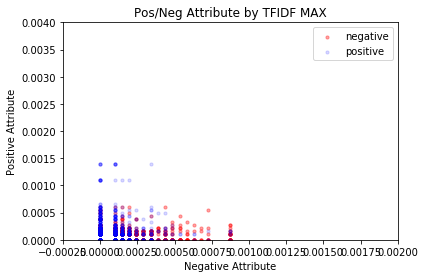

In [256]:
'''evaluate, same as above, but with new "trimmed" graphs, using TFIDF MAX'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "TFIDF_max")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "TFIDF_max")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

plt.xlim(-0.00025, 0.002)
plt.ylim(0, 0.004)
generatePlot(X, y, "TFIDF MAX")

kNN score: 0.5876777251184834
SVM score: 0.4792654028436019
Logistic regression score: 0.4792654028436019
Decision tree score: 0.5953791469194313


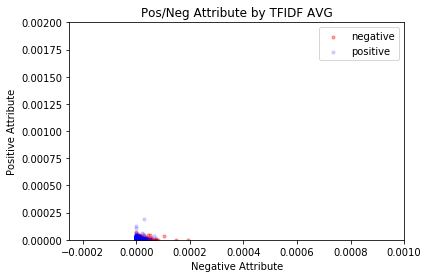

In [268]:
'''evaluate, same as above, but with new "trimmed" graphs, using TFIDF AVG'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraph, negWordGraph, "TFIDF_avg")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraph, negWordGraph, "TFIDF_avg")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "poly")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))

plt.xlim(-0.00025, 0.001)
plt.ylim(0, 0.002)
generatePlot(X, y, "TFIDF AVG")

kNN score: 0.5959715639810427
SVM score: 0.634478672985782
Logistic regression score: 0.6398104265402843
Decision tree score: 0.6131516587677726


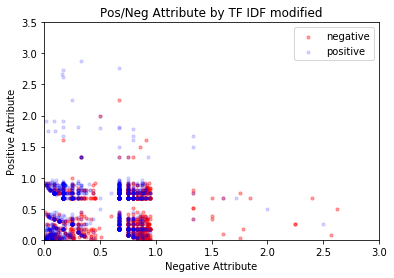

In [254]:
'''evaluate, same as above, but with new "trimmed" graphs, using TF IDF modified'''
X, y = generateWordGraphVectors(sentimentTweetDict, posWordGraphTrimmed, negWordGraphTrimmed, "TFIDF_2")
testDict = dfTest.to_dict(orient='index')
Xtest, ytest = generateWordGraphVectors(testDict, posWordGraphTrimmed, negWordGraphTrimmed, "TFIDF_2")

model = kNN(n_neighbors = 5)
model.fit(X, y)
print("kNN score: " + str(model.score(Xtest, ytest)))

classifier = svm.SVC(kernel = "linear")
classifier.fit(X, y)
print("SVM score: " + str(classifier.score(Xtest, ytest)))

classifier = logreg()
classifier.fit(X, y)
print("Logistic regression score: " + str(classifier.score(Xtest, ytest)))

classifier = dectree()
classifier.fit(X, y)
print("Decision tree score: " + str(classifier.score(Xtest, ytest)))


plt.xlim(0, 3)
plt.ylim(0, 3.5)
generatePlot(X, y, "TF IDF modified")